## Heart Disease UCI

#### INTRODUCTION

Classic dataset for predicting heart disease from 14 features (age, gender, chol etc.)

- https://www.kaggle.com/ronitf/heart-disease-uci
- https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Some other notebooks using this dataset:
- https://www.kaggle.com/roshansharma/heart-diseases-analysis
- https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model
- https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
- https://www.kaggle.com/kralmachine/analyzing-the-heart-disease
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4468223/

#### SETUP

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from scipy.stats import yeojohnson

import eli5
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC

_____

### LOAD DATA

In [191]:
uci_raw = pd.read_csv("../data/heart.csv")
print(uci_raw.shape)
uci_raw.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
print(uci_raw.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


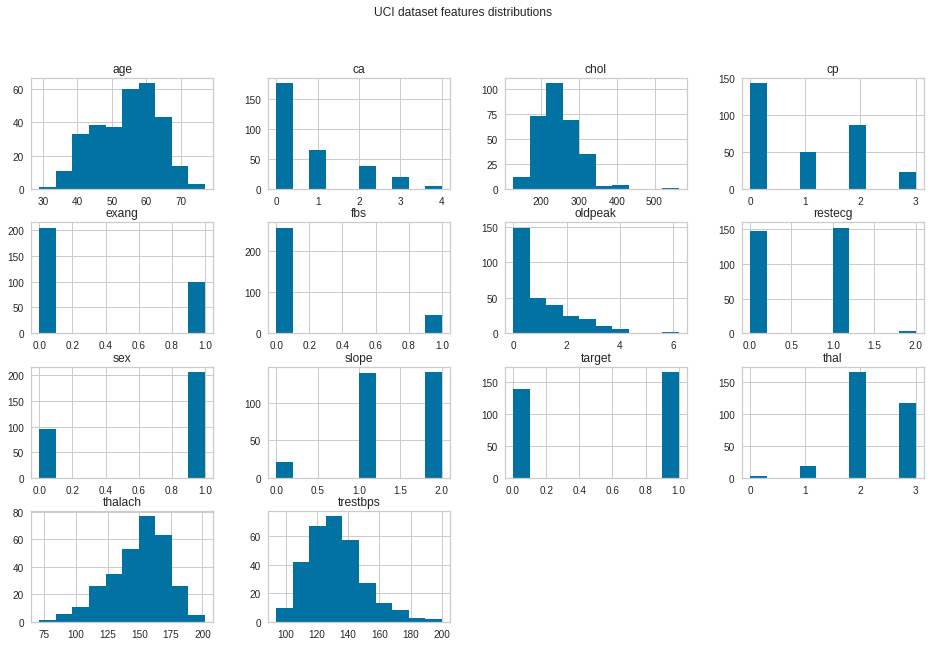

In [6]:
uci_raw.hist(figsize=(16, 10))
plt.suptitle("UCI dataset features distributions")
plt.show()

Baseline accuracy:

In [7]:
print(uci_raw['target'].value_counts())
print(uci_raw['target'].value_counts(normalize=True))

1    165
0    138
Name: target, dtype: int64
1    0.544554
0    0.455446
Name: target, dtype: float64


_____

### PREPROCESSING

In [192]:
target = "target"
all_columns = [col for col in uci_raw.columns if col != target]
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang']
numeric_columns = list(set(all_columns) - set(categorical_columns))

In [193]:
uci_raw.apply(lambda x: x.isnull().value_counts())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
False,303,303,303,303,303,303,303,303,303,303,303,303,303,303


The dataset is already cleaned without mising values. Few things that could be benefficial:
- adjust variables types - some are categorical but coded as integers
- one hot encode categorical variables
- scale continious variables (normalize)
- make some new features: ratios between continious

In [194]:
scaler = StandardScaler()

def preprocess_uci_data(df: pd.DataFrame, is_training = True, scaler=scaler) -> pd.DataFrame:
    df =  pd.get_dummies(df, prefix=categorical_columns, columns=categorical_columns, dummy_na=False)
    df[numeric_columns] = df[numeric_columns].astype(float)
    df['thalach_age'] = df['thalach'] / df['age']
    df['chol_trestbps'] =  df['chol'] / df['trestbps']
    df['thalach_trestbps'] = df['thalach'] / df['trestbps']
    
    if is_training:
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    else:
        df[numeric_columns] = scaler.transform(df[numeric_columns])
    return df

**Split & preprocess**

In [195]:
uci_shuffled = uci_raw.sample(frac=1, random_state=93)
y = uci_shuffled['target'].values
X = uci_shuffled.drop(['target'], axis = 1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [196]:
X_dev = preprocess_uci_data(X_dev, is_training=True, scaler=scaler)
X_test = preprocess_uci_data(X_test, is_training=False, scaler=scaler)
print(f"Development set shape: {X_dev.shape}"); print(f"Test set shape: {X_test.shape}")
assert(X_dev.shape[1] == X_test.shape[1])

Development set shape: (242, 24)
Test set shape: (61, 24)


In [197]:
X_dev.head().T

,302,250,58,83,178
age,0.316143,-0.336829,-2.186918,-0.228001,-1.207459
trestbps,-0.085303,0.496202,-0.783110,1.194008,-0.666809
chol,-0.142660,1.047812,-1.179523,1.047812,-1.275529
thalach,1.034228,-1.217455,1.034228,1.207434,-1.304058
oldpeak,-0.885882,2.702839,-0.885882,0.139467,1.250262
slope,-0.624947,-0.624947,0.983959,-0.624947,-0.624947
ca,0.254810,2.212400,-0.723985,-0.723985,-0.723985
thal,-0.515065,1.062730,-0.515065,1.062730,1.062730
sex_0,1.000000,0.000000,0.000000,0.000000,0.000000
sex_1,0.000000,1.000000,1.000000,1.000000,1.000000


_____

### INNITIAL TRAIN - MODELS COMPARISON

**Target space in 2D projectcion**

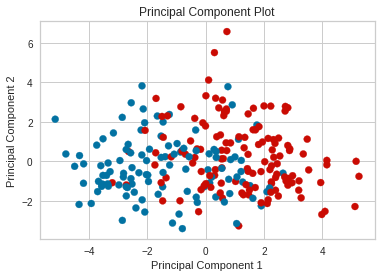

In [198]:
colors = np.array(['r' if yi else 'b' for yi in y_dev])
visualizer = PCADecomposition(scale=True, color=colors)
visualizer.fit_transform(X_dev, y_dev)
visualizer.poof()

**K-fold training loop**

In [199]:
%%time
models = [BernoulliNB, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier]
all_scores = []
for m in models:
    model = m()
    model_scores = []
    k_fold = KFold(n_splits=5, random_state=23)
    for train_index, val_index in k_fold.split(X_dev):
        X_train, X_val = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train, y_val = y_dev[train_index], y_dev[val_index]
        model.fit(X = X_train, y = y_train)
        preds = model.predict(X_val)
        score_test = f1_score(y_val, preds, average = 'macro')
        model_scores.append(score_test)
    all_scores.append(model_scores)

CPU times: user 104 ms, sys: 1.07 ms, total: 105 ms
Wall time: 104 ms


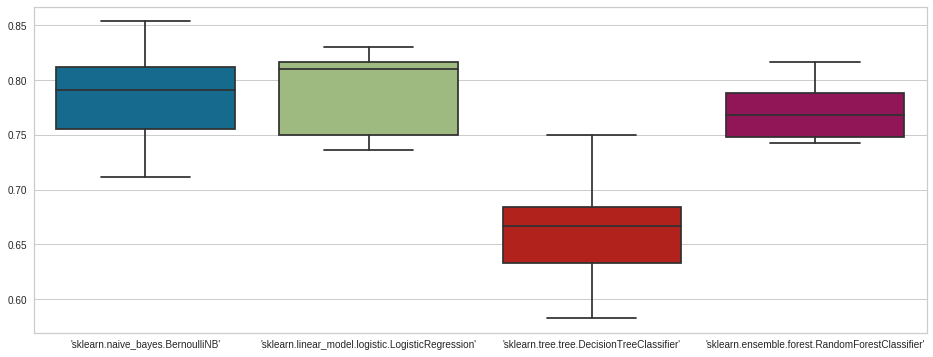

In [200]:
models_names = [re.findall(r"'[^'']*'", str(models[idx]))[0] for idx in range(len(models))]
plt.figure().set_size_inches(16, 6)
ax = sns.boxplot(x=models_names, y=all_scores)

____

#### SELECTED MODEL (LOGISTIC REGRESSION)

**Grid search for regularization strength**

In [64]:
search_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid_dict = {'C': search_values}
lc = LogisticRegression(solver = "lbfgs", random_state=123, max_iter=200)
grid_log = GridSearchCV(lc, grid_dict, cv=10, refit=True)
grid_log.fit(X_dev, y_dev)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

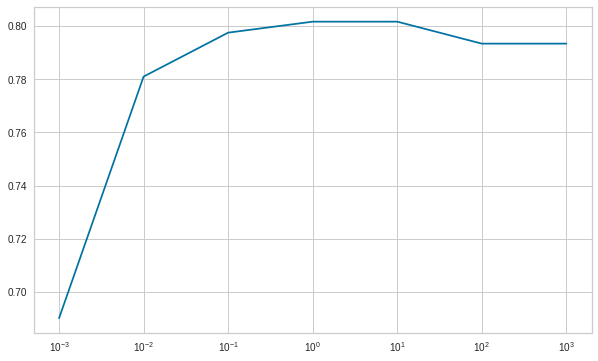

In [65]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(search_values, grid_log.cv_results_['mean_test_score'])
plt.show()

**Fit final model**

In [66]:
final_model = LogisticRegression(solver = "lbfgs", random_state=123, max_iter=200, C=0.1)
final_model.fit(X_dev, y_dev)
y_preds = final_model.predict(X_test)

_____

### VALIDATION

In [67]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        28
           1       0.87      1.00      0.93        33

    accuracy                           0.92        61
   macro avg       0.93      0.91      0.92        61
weighted avg       0.93      0.92      0.92        61



In [68]:
pd.DataFrame(confusion_matrix(y_test, y_preds))

,0,1
0,23,5
1,0,33


**ROC**

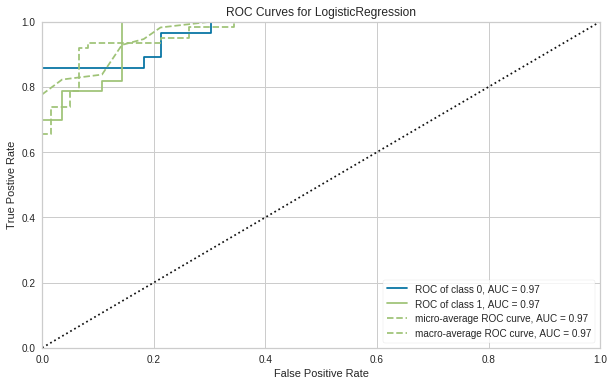

In [69]:
plt.figure().set_size_inches(10, 6)
visualizer = ROCAUC(final_model, classes=[0, 1])
visualizer.fit(X_dev, y_dev)
visualizer.score(X_test, y_test)
g = visualizer.poof()

**Precision vs Recall tradeoff**

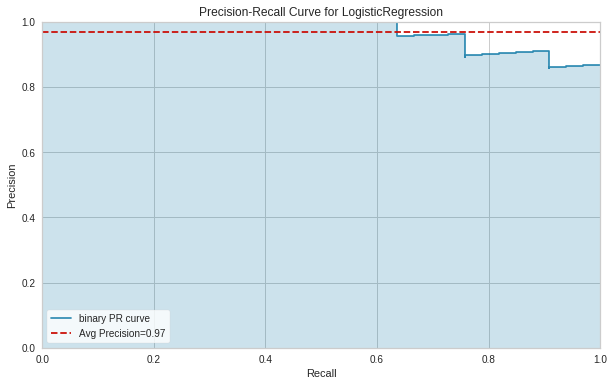

In [70]:
plt.figure().set_size_inches(10, 6)
viz = PrecisionRecallCurve(final_model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

**Coefficients**

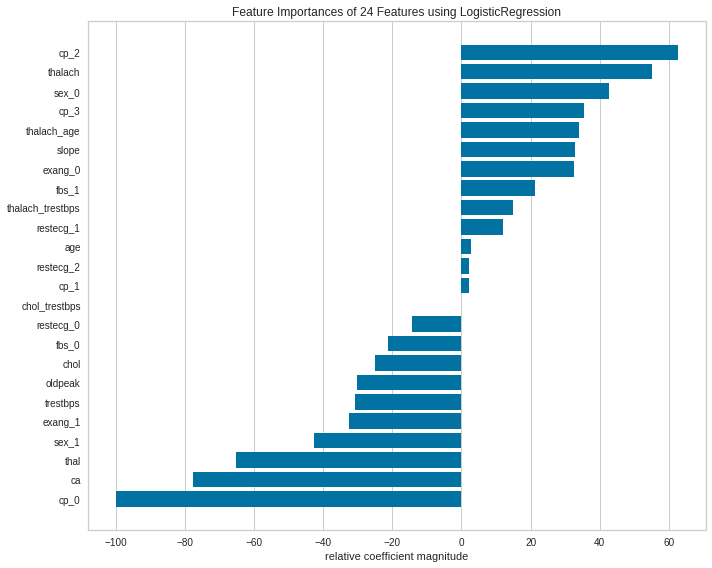

In [71]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot()
viz = FeatureImportances(final_model, ax=ax)
viz.fit(X_train, y_train)
viz.poof()

**Features explanation:**
- age in years
- sex(1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- cholserum - cholestoral in mg/dl
- fbs(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal3 = normal; 6 = fixed defect; 7 = reversable defect

[https://www.hindawi.com/journals/cmmm/2017/8272091/tab1/](https://www.hindawi.com/journals/cmmm/2017/8272091/tab1/)